# Purpose : Train Direct-Recursive Hybrid Model
- Purpose of this notebook is to build a direct-recursive hybrid model using LightGBM & sklearn RegressorChain

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# change current working directory to the root of the project
import os
os.chdir(os.path.dirname(os.getcwd()))

# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from IPython.display import display
import joblib
import warnings

from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import RegressorChain

import lightgbm as lgb
import optuna

from src import data_manipulate, pipeline_transformers, plot

# Import Data

In [2]:
# import csv data into pandas dataframe
df_data = pd.read_csv('data/preprocessed/data_preprocessed.csv')
df_holidays = pd.read_csv('data/preprocessed/holidays_preprocessed.csv')
df_stores = pd.read_csv('data/preprocessed/stores_preprocessed.csv')
df_oil = pd.read_csv('data/preprocessed/oil_preprocessed.csv')
df_transactions = pd.read_csv('data/preprocessed/transactions_preprocessed.csv')

In [3]:
print(f'{df_data.shape=}')
display(df_data.head())
print(f'{df_holidays.shape=}')
display(df_holidays.head())
print(f'{df_oil.shape=}')
display(df_oil.head())
print(f'{df_stores.shape=}')
display(df_stores.head())
print(f'{df_transactions.shape=}')
display(df_transactions.head())

df_data.shape=(3008016, 5)


,family,store_nbr,date,sales,onpromotion
0,AUTOMOTIVE,1,2013-01-01,0.0,0
1,AUTOMOTIVE,1,2013-01-02,2.0,0
2,AUTOMOTIVE,1,2013-01-03,3.0,0
3,AUTOMOTIVE,1,2013-01-04,3.0,0
4,AUTOMOTIVE,1,2013-01-05,5.0,0


df_holidays.shape=(330, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


df_oil.shape=(1704, 2)


,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12


df_stores.shape=(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


df_transactions.shape=(83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


# Convert data to multi-output format

- **7 day prediction horizon with 0 lead time**

In [4]:
multi_steps = data_manipulate.make_multistep_target(df_data, steps=7, lead_time=0)
df_data = df_data.merge(multi_steps, left_index=True, right_index=True)
df_data

,family,store_nbr,date,sales,onpromotion,multi_step_1,multi_step_2,multi_step_3,multi_step_4,multi_step_5,multi_step_6,multi_step_7
0,AUTOMOTIVE,1,2013-01-01,0.0,0,0.0,2.0,3.0,3.0,5.0,2.0,0.0
1,AUTOMOTIVE,1,2013-01-02,2.0,0,2.0,3.0,3.0,5.0,2.0,0.0,2.0
2,AUTOMOTIVE,1,2013-01-03,3.0,0,3.0,3.0,5.0,2.0,0.0,2.0,2.0
3,AUTOMOTIVE,1,2013-01-04,3.0,0,3.0,5.0,2.0,0.0,2.0,2.0,2.0
4,AUTOMOTIVE,1,2013-01-05,5.0,0,5.0,2.0,0.0,2.0,2.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3008005,SEAFOOD,54,2017-08-05,3.0,1,3.0,0.0,0.0,12.0,4.0,2.0,0.0
3008006,SEAFOOD,54,2017-08-06,0.0,0,0.0,0.0,12.0,4.0,2.0,0.0,1.0
3008007,SEAFOOD,54,2017-08-07,0.0,0,0.0,12.0,4.0,2.0,0.0,1.0,2.0
3008008,SEAFOOD,54,2017-08-08,12.0,0,12.0,4.0,2.0,0.0,1.0,2.0,0.0


# Add features

- **Add lag features to the data**


In [5]:
df_data['date'] = pd.to_datetime(df_data['date'])

# join transaction data to df_data
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
df_data = df_data.merge(df_transactions, on=['date', 'store_nbr'], how='left')

# join oil data to df_data
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_data = df_data.merge(df_oil, on='date', how='left')

In [6]:
# add sales lag features
lag_features = data_manipulate.add_lag_features(df_data, column='sales', lags=28, lead_time=1)
df_data = df_data.merge(lag_features, left_index=True, right_index=True)

# drop sales column
df_data.drop(columns=['sales'], inplace=True)

In [7]:
# add oil lag features
lag_features = data_manipulate.add_lag_features(df_data, column='dcoilwtico', lags=28, lead_time=1)
df_data = df_data.merge(lag_features, left_index=True, right_index=True)

# drop dcoilwtico column
df_data.drop(columns=['dcoilwtico'], inplace=True)

In [8]:
# add transactions lag features
lag_features = data_manipulate.add_lag_features(df_data, column='transactions', lags=28, lead_time=1)
df_data = df_data.merge(lag_features, left_index=True, right_index=True)

# drop dcoilwtico column
df_data.drop(columns=['transactions'], inplace=True)

-  **Add store features**

In [9]:
# rename type column in holidays to holiday_type
df_stores.rename(columns={'type': 'store_type'}, inplace=True)

# merge store data with df_data
df_data = df_data.merge(df_stores, on='store_nbr', how='left')
df_data

,family,store_nbr,date,onpromotion,multi_step_1,multi_step_2,multi_step_3,multi_step_4,multi_step_5,multi_step_6,...,transactions_lag_23,transactions_lag_24,transactions_lag_25,transactions_lag_26,transactions_lag_27,transactions_lag_28,city,state,store_type,cluster
0,AUTOMOTIVE,1,2013-01-01,0,0.0,2.0,3.0,3.0,5.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13
1,AUTOMOTIVE,1,2013-01-02,0,2.0,3.0,3.0,5.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13
2,AUTOMOTIVE,1,2013-01-03,0,3.0,3.0,5.0,2.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13
3,AUTOMOTIVE,1,2013-01-04,0,3.0,5.0,2.0,0.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13
4,AUTOMOTIVE,1,2013-01-05,0,5.0,2.0,0.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2997319,SEAFOOD,54,2017-08-05,1,3.0,0.0,0.0,12.0,4.0,2.0,...,683.0,692.0,767.0,840.0,1027.0,917.0,El Carmen,Manabi,C,3
2997320,SEAFOOD,54,2017-08-06,0,0.0,0.0,12.0,4.0,2.0,0.0,...,676.0,683.0,692.0,767.0,840.0,1027.0,El Carmen,Manabi,C,3
2997321,SEAFOOD,54,2017-08-07,0,0.0,12.0,4.0,2.0,0.0,1.0,...,855.0,676.0,683.0,692.0,767.0,840.0,El Carmen,Manabi,C,3
2997322,SEAFOOD,54,2017-08-08,0,12.0,4.0,2.0,0.0,1.0,2.0,...,920.0,855.0,676.0,683.0,692.0,767.0,El Carmen,Manabi,C,3


- **Add holiday features**

In [10]:
# rename type column in holidays to holiday_type
df_holidays.rename(columns={'type': 'holiday_type'}, inplace=True)

# merge holiday data with df_data
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_data = df_data.merge(df_holidays[['date', 'holiday_type', 'locale_name']], left_on=['city', 'date'], right_on=['locale_name', 'date'],  how='left')
df_data.drop(columns=['locale_name'], inplace=True)
df_data

,family,store_nbr,date,onpromotion,multi_step_1,multi_step_2,multi_step_3,multi_step_4,multi_step_5,multi_step_6,...,transactions_lag_24,transactions_lag_25,transactions_lag_26,transactions_lag_27,transactions_lag_28,city,state,store_type,cluster,holiday_type
0,AUTOMOTIVE,1,2013-01-01,0,0.0,2.0,3.0,3.0,5.0,2.0,...,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN
1,AUTOMOTIVE,1,2013-01-02,0,2.0,3.0,3.0,5.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN
2,AUTOMOTIVE,1,2013-01-03,0,3.0,3.0,5.0,2.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN
3,AUTOMOTIVE,1,2013-01-04,0,3.0,5.0,2.0,0.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN
4,AUTOMOTIVE,1,2013-01-05,0,5.0,2.0,0.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2997319,SEAFOOD,54,2017-08-05,1,3.0,0.0,0.0,12.0,4.0,2.0,...,692.0,767.0,840.0,1027.0,917.0,El Carmen,Manabi,C,3,NaN
2997320,SEAFOOD,54,2017-08-06,0,0.0,0.0,12.0,4.0,2.0,0.0,...,683.0,692.0,767.0,840.0,1027.0,El Carmen,Manabi,C,3,NaN
2997321,SEAFOOD,54,2017-08-07,0,0.0,12.0,4.0,2.0,0.0,1.0,...,676.0,683.0,692.0,767.0,840.0,El Carmen,Manabi,C,3,NaN
2997322,SEAFOOD,54,2017-08-08,0,12.0,4.0,2.0,0.0,1.0,2.0,...,855.0,676.0,683.0,692.0,767.0,El Carmen,Manabi,C,3,NaN


- **Add Trend**

In [11]:
df_data['trend'] = df_data.groupby(['family', 'store_nbr']).cumcount()

In [12]:
print(f'{df_data.shape=}')
display(df_data.head())

df_data.shape=(2997324, 101)


,family,store_nbr,date,onpromotion,multi_step_1,multi_step_2,multi_step_3,multi_step_4,multi_step_5,multi_step_6,...,transactions_lag_25,transactions_lag_26,transactions_lag_27,transactions_lag_28,city,state,store_type,cluster,holiday_type,trend
0,AUTOMOTIVE,1,2013-01-01,0,0.0,2.0,3.0,3.0,5.0,2.0,...,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN,0
1,AUTOMOTIVE,1,2013-01-02,0,2.0,3.0,3.0,5.0,2.0,0.0,...,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN,1
2,AUTOMOTIVE,1,2013-01-03,0,3.0,3.0,5.0,2.0,0.0,2.0,...,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN,2
3,AUTOMOTIVE,1,2013-01-04,0,3.0,5.0,2.0,0.0,2.0,2.0,...,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN,3
4,AUTOMOTIVE,1,2013-01-05,0,5.0,2.0,0.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN,4


# Train Test split

In [13]:
X_train, y_train, X_test, y_test = data_manipulate.train_test_split_multi_step(df_data, cutoff_date='2017-01-01')

In [14]:
print(f'{X_train.shape=}')
display(X_train.head())
print(f'{y_train.shape=}')
display(y_train.head())
print(f'{X_test.shape=}')
display(X_test.head())
print(f'{y_test.shape=}')
display(y_test.head())

X_train.shape=(2603502, 94)


,family,store_nbr,date,onpromotion,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,...,transactions_lag_25,transactions_lag_26,transactions_lag_27,transactions_lag_28,city,state,store_type,cluster,holiday_type,trend
0,AUTOMOTIVE,1,2013-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN,0
1,AUTOMOTIVE,1,2013-01-02,0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN,1
2,AUTOMOTIVE,1,2013-01-03,0,2.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN,2
3,AUTOMOTIVE,1,2013-01-04,0,3.0,2.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN,3
4,AUTOMOTIVE,1,2013-01-05,0,3.0,3.0,2.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NaN,4


y_train.shape=(2603502, 7)


,multi_step_1,multi_step_2,multi_step_3,multi_step_4,multi_step_5,multi_step_6,multi_step_7
0,0.0,2.0,3.0,3.0,5.0,2.0,0.0
1,2.0,3.0,3.0,5.0,2.0,0.0,2.0
2,3.0,3.0,5.0,2.0,0.0,2.0,2.0
3,3.0,5.0,2.0,0.0,2.0,2.0,2.0
4,5.0,2.0,0.0,2.0,2.0,2.0,3.0


X_test.shape=(393822, 94)


,family,store_nbr,date,onpromotion,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,...,transactions_lag_25,transactions_lag_26,transactions_lag_27,transactions_lag_28,city,state,store_type,cluster,holiday_type,trend
1461,AUTOMOTIVE,1,2017-01-01,0,2.0,4.0,3.0,12.0,5.0,0.0,...,2004.0,523.0,1887.0,568.0,Quito,Pichincha,D,13,NaN,1461
1462,AUTOMOTIVE,1,2017-01-02,0,0.0,2.0,4.0,3.0,12.0,5.0,...,1828.0,2004.0,523.0,1887.0,Quito,Pichincha,D,13,NaN,1462
1463,AUTOMOTIVE,1,2017-01-03,0,5.0,0.0,2.0,4.0,3.0,12.0,...,1881.0,1828.0,2004.0,523.0,Quito,Pichincha,D,13,NaN,1463
1464,AUTOMOTIVE,1,2017-01-04,0,4.0,5.0,0.0,2.0,4.0,3.0,...,1376.0,1881.0,1828.0,2004.0,Quito,Pichincha,D,13,NaN,1464
1465,AUTOMOTIVE,1,2017-01-05,0,1.0,4.0,5.0,0.0,2.0,4.0,...,572.0,1376.0,1881.0,1828.0,Quito,Pichincha,D,13,NaN,1465


y_test.shape=(393822, 7)


,multi_step_1,multi_step_2,multi_step_3,multi_step_4,multi_step_5,multi_step_6,multi_step_7
1461,0.0,5.0,4.0,1.0,2.0,2.0,5.0
1462,5.0,4.0,1.0,2.0,2.0,5.0,0.0
1463,4.0,1.0,2.0,2.0,5.0,0.0,2.0
1464,1.0,2.0,2.0,5.0,0.0,2.0,3.0
1465,2.0,2.0,5.0,0.0,2.0,3.0,10.0


# Define Custom Pipeline

In [15]:
# select numerical features
num_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]
num_cols.append('average_rides_last_4_weeks')
# select categorical features
cat_cols = [col for col in X_train.columns if X_train[col].dtype in ['object']]
# select boolean features
bool_cols = [col for col in X_train.columns if X_train[col].dtype in ['bool']]

In [16]:
# check missing values in categorical features
df_data[cat_cols].isna().sum()


family                0
city                  0
state                 0
store_type            0
holiday_type    2985939
dtype: int64

In [17]:
def custom_pipeline(**params):
    cat_cols_transformations = make_pipeline(
        pipeline_transformers.PandasSimpleImputer(strategy='constant', fill_value='no_holiday'), # only holiday_type column has missing values
        OneHotEncoder(handle_unknown='ignore')
    )

    num_cols_transformations = make_pipeline(
        pipeline_transformers.PandasSimpleImputer(strategy='median')
    )

    bool_cols_transformations = make_pipeline(
        OrdinalEncoder()
    )

    cols_trans = ColumnTransformer([
        ('bool', bool_cols_transformations, bool_cols),
        ('cat', cat_cols_transformations, cat_cols),
        ('num', num_cols_transformations, num_cols),
        ], remainder='passthrough'
        )

    pipeline = make_pipeline(
        pipeline_transformers.FourierFeatures(10),
        pipeline_transformers.add_temporal_features,
        pipeline_transformers.add_feature_average_rides_last_4_weeks,
        cols_trans,
        MinMaxScaler(),
        RegressorChain(lgb.LGBMRegressor(**params, verbose_eval=None), order=[0, 1, 2, 3, 4, 5, 6])
        )
    
    return pipeline

# Hyper-parameter Tuning

In [18]:
# Define hyper-parameters & objective function
# define objective function
def objective(trial: optuna.trial.Trial) -> float:
    '''Takes in hyperparameters as input, and trains a model that computes the average validation error based on TimeSeriesSplit cross validation'''

    # define hyperparameters
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 3, 100),   
    }

    tss = TimeSeriesSplit(n_splits=10)
    scores = []
    for train_index, val_index in tss.split(X_train):

        # split data
        X_train_, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # create model
        pipeline = custom_pipeline(**params)

        # fit model
        pipeline.fit(X_train_, y_train_)

        # compute validation error
        y_pred = pipeline.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)

        scores.append(mae)
    
    return np.mean(scores)

In [19]:
import warnings
warnings.filterwarnings('ignore')

# optuna study
study = optuna.create_study(direction='minimize', study_name='direct_recursive_hybrid_lightgbm')
study.optimize(objective, n_trials=10)

[I 2023-03-16 10:19:04,294] A new study created in memory with name: direct_recursive_hybrid_lightgbm
[I 2023-03-16 10:41:01,216] Trial 0 finished with value: 133.62093436221204 and parameters: {'num_leaves': 249, 'colsample_bytree': 0.7100315566189883, 'subsample': 0.4048289808366189, 'min_child_samples': 68}. Best is trial 0 with value: 133.62093436221204.
[I 2023-03-16 11:02:27,381] Trial 1 finished with value: 134.0737124625739 and parameters: {'num_leaves': 178, 'colsample_bytree': 0.5579778528176336, 'subsample': 0.203588004892198, 'min_child_samples': 46}. Best is trial 0 with value: 133.62093436221204.
[I 2023-03-16 11:17:03,133] Trial 2 finished with value: 136.83495372580515 and parameters: {'num_leaves': 43, 'colsample_bytree': 0.4448274794707512, 'subsample': 0.24672125828683367, 'min_child_samples': 87}. Best is trial 0 with value: 133.62093436221204.
[I 2023-03-16 11:38:00,748] Trial 3 finished with value: 134.68394571935045 and parameters: {'num_leaves': 187, 'colsample_

In [20]:
# print best parameters
best_params = study.best_trial.params
print(f'{best_params=}')

best_params={'num_leaves': 249, 'colsample_bytree': 0.7100315566189883, 'subsample': 0.4048289808366189, 'min_child_samples': 68}


In [21]:
best_params={'num_leaves': 230, 'colsample_bytree': 0.7155855256756458, 'subsample': 0.745333378926408, 'min_child_samples': 45}

In [22]:
# fit best params on full training set
pipeline = custom_pipeline(**best_params)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('fourierfeatures',
                 <src.pipeline_transformers.FourierFeatures object at 0x29a229970>),
                ('functiontransformer-1',
                 FunctionTransformer(func=<function extract_temporal_features at 0x2812ff4c0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x2812d4ee0>)),
                ('columntransformer',
                 ColumnTransformer(remainder...
                                                   'sales_lag_22',
                                                   'sales_lag_23',
                                                   'sales_lag_24',
                                                   'sales_lag_25',
                                                   'sales_lag_26',
                                                   'sales_lag_27',
                                                   'sales_lag_28', ...])])),
                ('minmaxscaler', MinMaxScaler()),
                ('regressorchain',
                 RegressorChain(base_estimator=LGBMRegressor(colsample_bytree=0.7155855256756458,
                                                             min_child_samples=45,
                                                             num_leaves=230,
                                                             subsample=0.745333378926408,
                                                             verbose_eval=None),
                                order=[0, 1, 2, 3, 4, 5, 6]))])

In [23]:
import joblib
# save model using joblib
joblib.dump(pipeline, 'models/direct_recursive_lightgbm.pkl')

['models/direct_recursive_lightgbm.pkl']

In [24]:
# compute test error on test set
predictions = pipeline.predict(X_test)

# convert negative predctions to 0
predictions[predictions < 0] = 0

predictions = pd.DataFrame(predictions, columns=y_test.columns, index=y_test.index)

display(y_test.head())
display(pd.DataFrame(predictions).head())

test_mae = mean_absolute_error(y_test, predictions)
print(f'{test_mae=:.4f}')

,multi_step_1,multi_step_2,multi_step_3,multi_step_4,multi_step_5,multi_step_6,multi_step_7
1461,0.0,5.0,4.0,1.0,2.0,2.0,5.0
1462,5.0,4.0,1.0,2.0,2.0,5.0,0.0
1463,4.0,1.0,2.0,2.0,5.0,0.0,2.0
1464,1.0,2.0,2.0,5.0,0.0,2.0,3.0
1465,2.0,2.0,5.0,0.0,2.0,3.0,10.0


,multi_step_1,multi_step_2,multi_step_3,multi_step_4,multi_step_5,multi_step_6,multi_step_7
1461,0.000000,16.782359,5.579532,7.523757,4.004566,5.853419,4.182192
1462,8.603349,7.043609,11.046517,6.419267,8.913923,4.991141,3.116884
1463,3.711973,8.447250,3.186820,4.465847,5.463406,1.882879,2.648252
1464,5.025140,3.555272,4.119516,3.409239,2.327219,3.106625,2.053644
1465,2.160976,2.201742,3.526056,2.500096,2.481376,3.742880,0.634272


test_mae=73.4028


# Plot Predictions

In [25]:
# join predictions to X_test store_nbr and family

prediction_test_set = X_test[['store_nbr', 'family', 'date']].merge(pd.DataFrame(predictions), left_index=True, right_index=True, how='left')
prediction_test_set.rename(columns={0: 'multi_step_1', 1: 'multi_step_2', 2: 'multi_step_3', 3: 'multi_step_4', 4: 'multi_step_5', 5: 'multi_step_6', 6: 'multi_step_7'}, inplace=True)

# join y_test to X_test store_nbr and family
actual_test_set = X_test[['store_nbr', 'family', 'date']].merge(y_test, left_index=True, right_index=True, how='left')

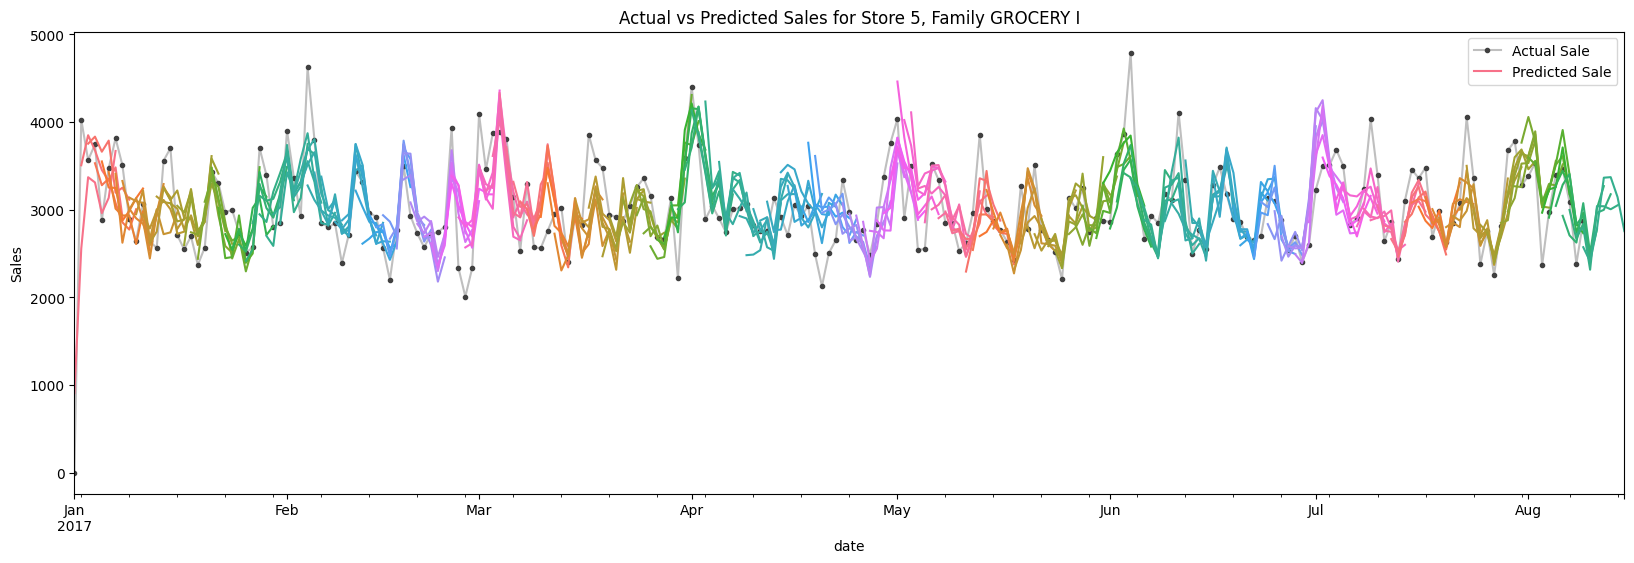

In [26]:
plot.plot_predictions(prediction_test_set, actual_test_set, 5, 'GROCERY I')

# Summary
- **Direct-recursive Hybrid**
    - MAE = 73.4028